# 使用特征匹配和单应性查找对象

## 特征点匹配流程

1. 使用特征搜寻算法
     + `cv2.xfeatures2d.SIFT_create()`
     + `cv2.ORB_create()`
     + `cv2.xfeatures2d.SURF_create()`
     + `cv2.xfeatures2d.StarDetector_create()`
     
  得到img_train和img_query上特征点
  
2. 使用特征计算子分别得到img_train和img_query的特征点位置
    + `sift.detect(img, mask)`
    + `orb.detect(img, mask)`
    + `surf.detect(img, mask)`
    + `star.detect(img, mask)`
    
3. 使用特征描述子分别得到img_train和img_query的特征向量表示
    + `sift.compute(img, kps)`
    + `orb.compute(img, kps)`
    + `surf.compute(img, kps)`
    + `star.compute(img, kps)`
    + `cv2.xfeatures2d.BriefDescriptorExtractor_create().compute()`
    
4. 使用特征匹配算法得到img_train和img_query上对应匹配的特征
    + `cv2.BFMatcher()`
        + `bf.match(des_query, dex_train)`（一对一匹配）
        + `bf.knnMatch(des_query, dex_train)`(一对多匹配)
    + `cv2.FlannBaseMatcher()`
        + `flann.match(des_query, dex_train)`（一对一匹配）
        + `flann.knnMatch(des_query, dex_train)`(一对多匹配)
        
5. 展示特征点或对应匹配的特征点
    + `cv2.drawMatches()`
    + `cv2.drawMatchesKnn()`
    
    
如果将两幅图像的特征点集传给`cv2.findHomography()`函数，它就可以找到这个对象的透视变换，然后就可以使用函数`cv2.perspectiveTransform()`找到这个对象了。

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def cv2_imread(img_path, flag=None):
    if flag is None or flag > 0:
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif flag == 0:
        img = cv2.imread(str(img_path), flag)
    else:
        msg = 'unknow flag code: {}'.format(flag)
        raise ValueError(msg)
    return img

def display_img(img, cmap=None):
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot()
    if cmap is None or cmap == 'plamsa':
        ax.imshow(img)
    else:
        ax.imshow(img, cmap=cmap)
    ax.set_title(f'shape: {img.shape}')
    ax.axis('off')
    plt.show()

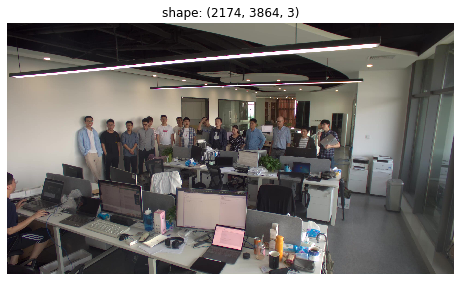

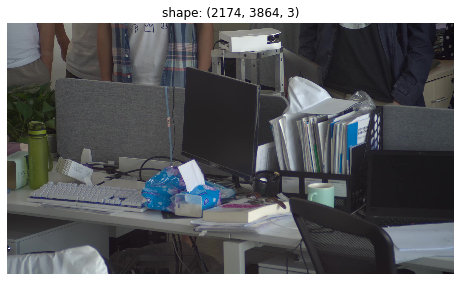

In [4]:
img_train = cv2_imread('./imgdata/stitching_sets/mantis70/kunshan_jun14/1/mcam_5013.jpeg')
img_query = cv2_imread('./imgdata/stitching_sets/mantis70/kunshan_jun14/1/mcam_5017.jpeg')

display_img(img_train)
display_img(img_query)

In [5]:
img_train = cv2.cvtColor(img_train, cv2.COLOR_RGB2GRAY)
img_query = cv2.cvtColor(img_query, cv2.COLOR_RGB2GRAY)

In [6]:
sift = cv2.xfeatures2d.SIFT_create()
kps_train, des_train = sift.detectAndCompute(img_train, None)
kps_query, des_query = sift.detectAndCompute(img_query, None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des_query, des_train, k=2)

good = []
for feature1, feature2 in matches:
    if feature1.distance < 0.7 * feature2.distance:
        good.append(feature1)

如果找到了足够的匹配，我们要提取两幅图像中匹配的坐标，把它们传入到函数中计算透视变换，一旦我们找到了3x3的变换矩阵，就可以使用它将查询图像的四个顶点变换到目标图像中去了。

In [7]:
if len(good) > 10:
    # 分别获取匹配到的关键点在img_train和img_query上的坐标
    src_kpts = np.float32([kps_query[feature.queryIdx].pt for feature in good])
    dst_kpts = np.float32([kps_train[feature.trainIdx].pt for feature in good])
    print(src_kpts.size)
    src_kpts = src_kpts.reshape(-1, 1, 2)
    dst_kpts = dst_kpts.reshape(-1, 1, 2)
else:
    print('Not enough matches are found - {len(good)}/{10}')

604


`cv2.findHomography(srcPoints, dstPoints[, method[, ransacReprojThreshold[, mask[, maxIters[, confidence]]]]])`

至少需要4个正确的特征点才能有效果，因此在传入特征点时一定要检查特征点的数目是否满足要求

+ Inputs：
    + srcPoints
    + dstPoints
    + method:指定计算homography所使用的算法
        + 0：一般方法
        + cv2.RANSAC
        + cv2.LMEDS
    + ransacReprojThreshold:取值范围为[1, 10]，当匹配点之间的距离小于该值时会被认为为outlier。原图像的点经过变换后与目标图像上的对应点之间的误差超过该值时就被认为是outlier
    
+ Returns:
    + M:转换矩阵（3x3）
    + mask:指定了inlier和outlier

1. 计算img_train和img_query上的特征
2. 匹配img_train和img_query上对应的特征
3. 根据匹配到的特征得到img_query到img_train的透视变换矩阵
4. 将透视变化

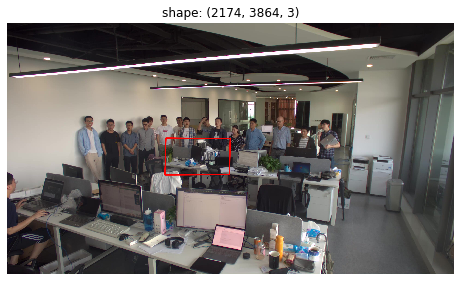

In [8]:
M, mask = cv2.findHomography(src_kpts, dst_kpts, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()

# 使用得到的变换矩阵对原图像的四个角进行变换，获得在目标图像对象的坐标
h, w = img_query.shape
pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, M)

img_train_rgb = cv2_imread('./imgdata/stitching_sets/mantis70/kunshan_jun14/1/mcam_5013.jpeg')
img_train_rgb_copy = img_train_rgb.copy()
cv2.polylines(img_train_rgb_copy, [np.int32(dst)], True, 255, 10, cv2.LINE_AA)

display_img(img_train_rgb_copy)

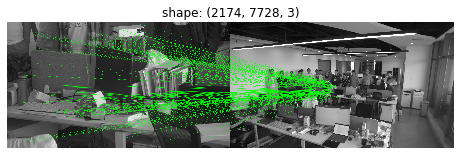

In [9]:
draw_params = dict(matchColor = (0, 255, 0), 
                   singlePointColor = None, 
                   matchesMask = matchesMask, 
                   flags = 2)

match_img = cv2.drawMatches(img_query, 
                            kps_query, 
                            img_train, 
                            kps_train, 
                            good, 
                            None, 
                            **draw_params)

display_img(match_img)

将全景图中对应部分图像wrap出来。

`cv2.warpPerspective(src, dst, mapMatrix, flags=CV_INTER_LINEAR+CV_WARP_FILL_OUTLIERS, fillval=(0, 0, 0, 0))`

Parameters:	
+ src – input image.
+ dst – output image that has the size dsize and the same type as src .
+ M – 3\times 3 transformation matrix.
+ dsize – size of the output image.
+ flags – combination of interpolation methods (INTER_LINEAR or INTER_NEAREST) and the optional flag WARP_INVERSE_MAP, that sets M as the inverse transformation ( \texttt{dst}\rightarrow\texttt{src} ).
+ borderMode – pixel extrapolation method (BORDER_CONSTANT or BORDER_REPLICATE).
+ borderValue – value used in case of a constant border; by default, it equals 0.

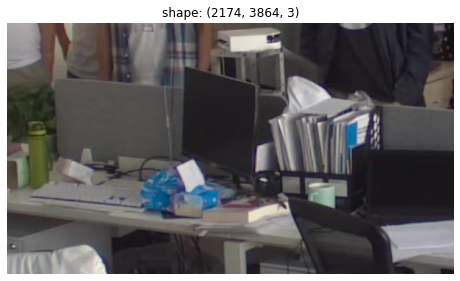

In [12]:
img_train_rgb_copy = cv2_imread('./imgdata/stitching_sets/mantis70/kunshan_jun14/1/mcam_5013.jpeg')

h_, w_ = img_train_rgb_copy.shape[:2]
img_train_wrapped = cv2.warpPerspective(img_train_rgb_copy, M, (w_, h_), None, cv2.WARP_INVERSE_MAP+cv2.INTER_AREA)
display_img(img_train_wrapped)

调节warp出来的图像各通道的亮度。

In [61]:
def single_channel_linear_brightness_correct(src_img, ref_img):
    src_shape = src_img.shape
    src = src_img.flatten()
    ref = ref_img.flatten()
    
    # 处理亮度值为0和255的像素（这些像素被认为是曝光不正常的像素）
    if False:
        ref_bad_pixel = np.concatenate([np.argwhere(ref == 0), np.argwhere(ref == 255)], axis = 0)
        ref = np.delete(ref, ref_bad_pixel)
        src_bad_pixel = np.concatenate([np.argwhere(src == 0), np.argwhere(ref == 255)], axis = 0)
        src = np.delete(src, src_bad_pixel)
    
    ref_mean = np.mean(ref)
    ref_std = np.std(ref)
    src_mean = np.mean(src)
    src_std = np.std(src)
    
    src = ((src - src_mean) / src_std) * ref_std + ref_mean
    src = np.clip(src, 0, 1)
    src = src.reshape(src_shape)
    
    return src

def linear_brightness_correct(src_img, ref_img):
    assert src_img.dtype is np.dtype('uint8') and ref_img.dtype is np.dtype('uint8')
    
    channel = src_img.shape[-1]
    out_img = np.zeros(src_img.shape, dtype=np.uint8)
    src = src_img.astype(np.float) / 255.
    ref = ref_img.astype(np.float) / 255.
    
    for c in range(channel):
        out_c = single_channel_linear_brightness_correct(src[..., c], ref[..., c])
        out_img[..., c] = np.clip(np.round(out_c*255), 0, 255).astype('uint8')
        
    return out_img

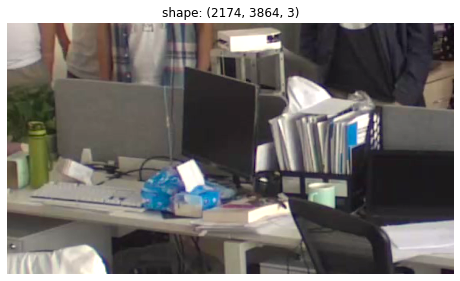

In [62]:
img_correct = linear_brightness_correct(img_train_wrapped, img_train_rgb_copy)
display_img(img_correct)

1. 计算img_train和img_query中的特征点
2. 搜寻img_train 和img_query相匹配的特征点
3. 根据匹配的特征点得到转换矩阵M
4. 根据转换矩阵M将img_train中对应img_query部分的图像inverse warp出来，记为train_wrap
5. 将train_wrap对照img_query进行亮度调节